# Train WaveNet

In [1]:
from wavenet_model import WaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Setup Model

In [2]:
train_samples = ["train_samples/hihat.wav"]
sampling_rate = 44100
init_model = None

layers = 7
blocks = 2
classes = 128
dilation_channels = 64
residual_channels = 64
skip_channels = 64
kernel_size = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [3]:
model = WaveNetModel(layers=layers,
                     blocks=blocks,
                     dilation_channels=dilation_channels,
                     residual_channels=residual_channels,
                     skip_channels=skip_channels,
                     classes=classes,
                     kernel_size=kernel_size,
                     dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)
print("parameter count: ", model.parameter_count())

if init_model != None:
    if use_cuda:
        model.load_state_dict(torch.load(init_model))
    else:
        # move to cpu
        model.load_state_dict(torch.load(init_model, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              receptive_field=model.receptive_field,
                              target_length=model.output_length,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive_field:  318
parameter count:  352448
total duration of training data:  0.6  s


In [4]:
data_loader.start_new_epoch()
start_data = data_loader.get_wavenet_minibatch([model.receptive_field], 
                                               model.receptive_field,
                                               model.output_length)[0]
start_data = start_data.squeeze()

plt.ion()
plt.plot(start_data[-200:].numpy())
plt.ioff()

There are not enough segments available in the training set to produce one chunk


AttributeError: 'AudioFileLoader' object has no attribute 'get_wavenet_minibatch'

## Train Model

In [9]:
learning_rate = 0.001
mini_batch_size = 4
report_interval = 4
test_interval = 16
snapshot_interval = 256
epochs = 200
segments_per_chunk=16
examples_per_segment=8
test_segments = 4
examples_per_test_segment = 4
model_path = "model_parameters/hihat_7-2-128-64-64-64-2"

In [10]:
def report_callback(opt):
    ax.clear()
    ax.plot(opt.loss_positions, opt.losses)
    ax.plot(opt.test_result_positions, opt.test_results)
    fig.canvas.draw()
    
#def test_callback(test_results, positions):
    
optimizer = WaveNetOptimizer(model,
                             data=data_loader,
                             test_segments=test_segments,
                             examples_per_test_segment=examples_per_test_segment,
                             report_callback=report_callback,
                             report_interval=report_interval,
                             test_interval=test_interval,
                             test_report_callback=None,
                             snapshot_interval=snapshot_interval,
                             snapshot_file=model_path)


The test set has a total duration of  0.023219954648526078  s


<IPython.core.display.Javascript object>


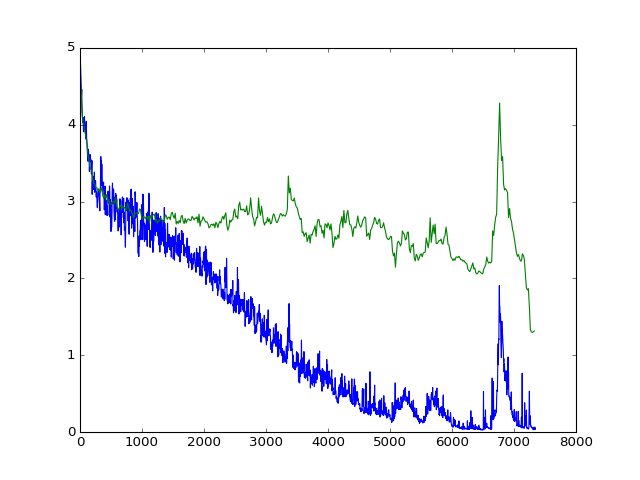

start training...
epoch  0
load new chunk with start segment index  0
load new chunk with start segment index  18
load new chunk with start segment index  35
epoch  1
load new chunk with start segment index  4
load new chunk with start segment index  23
load new chunk with start segment index  41
epoch  2
load new chunk with start segment index  8
load new chunk with start segment index  26
load new chunk with start segment index  45
epoch  3
load new chunk with start segment index  13
2017-05-18 15:19:04.085911 : snapshot saved to  model_parameters/hihat_7-2-128-64-64-64-2
load new chunk with start segment index  30
load new chunk with start segment index  50
epoch  4
load new chunk with start segment index  19
load new chunk with start segment index  37
epoch  5
load new chunk with start segment index  4
load new chunk with start segment index  23
load new chunk with start segment index  40
epoch  6
load new chunk with start segment index  10
2017-05-18 15:20:11.682383 : snapshot sav

KeyboardInterrupt: 

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

print('start training...')
tic = time.time()
optimizer.train(learning_rate=learning_rate,
                minibatch_size=mini_batch_size,
                epochs=epochs,
                segments_per_chunk=segments_per_chunk,
                examples_per_segment=examples_per_segment)
toc = time.time()
print('Training took {} seconds.'.format(toc-tic))

In [ ]:
torch.save(model.state_dict(), model_path)